In [ ]:
import pandas as pd
import numpy as np
import os
import keras
from keras import Model
from keras.layers import Concatenate

In [ ]:
df = pd.read_csv("../package/data/feature_metadata.csv")

In [ ]:
df.head()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

bedroom_image_path = df.loc[0, "bedroom"]
bathroom_image_path = df.loc[0, "bathroom"]
kitchen_image_path = df.loc[0, "kitchen"]
frontal_image_path = df.loc[0, "frontal"]
# Read the image using matplotlib

f, axarr = plt.subplots(2, 2, figsize=(10, 10))
# Read the images
img_bedroom = mpimg.imread(bedroom_image_path)
img_bathroom = mpimg.imread(bathroom_image_path)
img_kitchen = mpimg.imread(kitchen_image_path)
img_frontal = mpimg.imread(frontal_image_path)

# Display the images in a 2x2 grid
axarr[0, 0].imshow(img_bedroom)
axarr[0, 0].axis("off")  # Turn off axis

axarr[0, 1].imshow(img_bathroom)
axarr[0, 1].axis("off")  # Turn off axis

axarr[1, 0].imshow(img_kitchen)
axarr[1, 0].axis("off")  # Turn off axis

axarr[1, 1].imshow(img_frontal)
axarr[1, 1].axis("off")  # Turn off axis
plt.show()

In [ ]:
from typing import List
from typing import Tuple


class MultiInputModel:
    def __init__(
        self, images_shape: List[Tuple], numerical_shape: int, output_shape: int = 1
    ):
        self.images_shape = images_shape
        self.numerical_shape = numerical_shape
        self.output_shape = output_shape
        self.model = None

    def create_image_processors(
        self, names: List[str] = ["bedroom", "bathroom", "kitchen", "frontal"]
    ):
        """
        Create image processors for each image shape in the list.

        Returns:
            List of Keras models for each image shape.
        """
        for image_shape, name in zip(self.images_shape, names):
            x_im_i, x_im = self.image_processor(image_shape, preffix=name)
            if hasattr(self, "image_model_inputs"):
                self.image_model_inputs.append(x_im_i)
            if hasattr(self, "image_model_outputs"):
                self.image_model_outputs.append(x_im)
            else:
                self.image_model_outputs = [x_im]
                self.image_model_inputs = [x_im_i]

        return self.image_model_inputs, self.image_model_outputs
        # self.image_models = [x_im_i]
        # for image_shape, name in zip(self.images_shape, names):
        #     image_model = self.image_processor(image_shape, suffix=name)
        #     if hasattr(self, 'image_models'):
        #         self.image_models.append(image_model)
        #     else:
        #         self.image_models = [image_model]
        # return self.image_models

    def image_processor(self, input_image_shape, preffix: str, output_shape: int = 4):
        # Image input layer
        x_im_i = keras.Input(shape=input_image_shape, name=f"{preffix}_image_input")
        for n, f in enumerate([16, 32, 64]):
            if n == 0:
                x_im = x_im_i

            x_im = keras.layers.Conv2D(f, (3, 3), activation="relu")(x_im)
            x_im = keras.layers.MaxPool2D((2, 2))(x_im)
            x_im = keras.layers.BatchNormalization()(x_im)

        x_im = keras.layers.Flatten()(x_im)
        x_im = keras.layers.Dense(16, activation="relu")(x_im)
        x_im = keras.layers.BatchNormalization()(x_im)
        x_im = keras.layers.Dense(output_shape, activation="relu")(x_im)

        # model = Model(inputs = x_im_i, outputs = x_im)
        return x_im_i, x_im

    def get_numerical_processor(self, ouput_shape: int = 4):
        """
        Create a Keras model for processing numerical data.

        :param input_num_shape: Shape of the numerical input data.
        :param ouput_shape: Shape of the output data. Default is 4.
        :return: A Keras model for processing numerical data.
        """
        # Numerical and categorical input layer
        x_num_i = keras.Input(shape=self.numerical_shape, name="numerical_input")
        x_num = keras.layers.Dense(16, activation="relu")(x_num_i)
        x_num = keras.layers.Dense(ouput_shape, activation="relu")(x_num)

        model = Model(inputs=x_num_i, outputs=x_num)
        return model

    def build_model(self):
        """
        Build the final model by concatenating the outputs of image and numerical processors.

        :return: A Keras model that combines image and numerical data processing.
        """
        # Create models for image and numerical data processing
        im_inputs, im_outputs = self.create_image_processors()
        numerical_model = self.get_numerical_processor()

        # Get the outputs of the models
        # image_outputs = [model.output for model in image_models]
        numerical_output = numerical_model.output

        # combining the two ways
        mix_layer = Concatenate()(im_outputs + [numerical_output])

        # dense layers
        x = keras.layers.Dense(4, activation="relu")(mix_layer)
        x = keras.layers.Dense(self.output_shape, activation="linear")(x)

        # creating the model

        model = Model(inputs=im_inputs + [numerical_model.input], outputs=x)

        return model

In [ ]:
multi_model = MultiInputModel(
    [(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)], (4,)
)
model = multi_model.build_model()

In [ ]:
# use adam optimizer
optimizer = keras.optimizers.Adamax(learning_rate=0.001, decay=1e-3 / 200)

# use mean absolute error as loss function
model.compile(optimizer=optimizer, loss="mean_absolute_percentage_error")

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def get_image_data(image_path: str):
    """
    Load and preprocess image data.

    :param image_path: Path to the image file.
    :param image_shape: Desired shape of the image.
    :return: Preprocessed image data.
    """
    # Load the image
    img = mpimg.imread(image_path)
    return img


def get_train_test_data():
    bedroom_images = []
    bathroom_images = []
    kitchen_images = []
    frontal_images = []
    numerical_data = []
    target = []
    for i in range(len(df)):
        # Get the target value
        target.append(df.loc[i, "price"])
        # Get the image paths and numerical data
        img = mpimg.imread(df.loc[i, "bedroom"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        print("bedroom shape", img.shape)
        bedroom_images.append(img)

        img = mpimg.imread(df.loc[i, "bathroom"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        print("bathroom shape", img.shape)
        bathroom_images.append(img)

        img = mpimg.imread(df.loc[i, "kitchen"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        print("kitchen shape", img.shape)
        kitchen_images.append(img)

        img = mpimg.imread(df.loc[i, "frontal"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        # print("frontal shape", img.shape)
        print("frontal shape", img.shape)
        frontal_images.append(img)

        numerical_data.append(df.loc[i][0:4].values)

    # Convert lists to numpy arrays
    bedroom_images = np.array(bedroom_images).astype(np.float32)
    bathroom_images = np.array(bathroom_images).astype(np.float32)
    kitchen_images = np.array(kitchen_images).astype(np.float32)
    frontal_images = np.array(frontal_images).astype(np.float32)
    textual_data = np.array(numerical_data).astype(np.float32)

    # reshape textual data to look like (4,)
    textual_data = np.reshape(textual_data, (textual_data.shape[0], 4))

    image_data = np.array(
        [bedroom_images, bathroom_images, kitchen_images, frontal_images]
    )

    return image_data, textual_data, target

In [ ]:
image_data, textual_data, target = get_train_test_data()

In [ ]:
# standardize the numerical data
textual_scaler = StandardScaler()
textual_data = textual_scaler.fit_transform(textual_data)

# minmax scale for the target
target = target / max(target)

In [ ]:
def get_train_test_split(
    image_data, textual_data, target, total_data: int, test_size: float = 0.2
):
    """
    Split the data into training and testing sets.

    :param image_data: Image data.
    :param textual_data: Textual data.
    :param total_data: Total number of samples.
    :param test_size: Proportion of the dataset to include in the test split.
    :return: Training and testing data splits.
    """
    # Split the data into training and testing sets
    train_size = int(total_data * (1 - test_size))
    X_train_image, X_test_image = [], []
    X_train, X_test = [], []
    y_train, y_test = [], []

    indexes = np.arange(total_data)
    np.random.shuffle(indexes)

    for i in range(total_data):
        index = indexes[i]
        if i < train_size:
            X_train_image.append(
                [
                    image_data[0][index],
                    image_data[1][index],
                    image_data[2][index],
                    image_data[3][index],
                ]
            )
            X_train.append(textual_data[index])
            y_train.append(target[index])
        else:
            X_test_image.append(
                [
                    image_data[0][index],
                    image_data[1][index],
                    image_data[2][index],
                    image_data[3][index],
                ]
            )
            X_test.append(textual_data[index])
            y_test.append(target[index])

    X_train_image = np.array(X_train_image)
    X_test_image = np.array(X_test_image)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train, X_test, X_train_image, X_test_image, y_train, y_test

In [ ]:
len(target)

In [ ]:
X_train, X_test, X_train_image, X_test_image, y_train, y_test = get_train_test_split(
    image_data, textual_data, target, len(df), test_size=0.2
)

In [ ]:
from mlflow.models import infer_signature
from mlflow.types.schema import TensorSpec
from mlflow.types.schema import Schema
from mlflow.models import ModelSignature
import mlflow

In [ ]:
image1 = TensorSpec(
    shape=(-1, 128, 128, 3), type=np.dtype(np.float32), name="bedroom_image_input"
)
image2 = TensorSpec(
    shape=(-1, 128, 128, 3), type=np.dtype(np.float32), name="bathroom_image_input"
)
image3 = TensorSpec(
    shape=(-1, 128, 128, 3), type=np.dtype(np.float32), name="kitchen_image_input"
)
image4 = TensorSpec(
    shape=(-1, 128, 128, 3), type=np.dtype(np.float32), name="frontal_image_input"
)
numerical = TensorSpec(shape=(-1, 4), type=np.dtype(np.float32), name="numerical_input")
output = TensorSpec(shape=(-1, 1), type=np.dtype(np.float32), name="output")
input_schema = Schema(inputs=[image1, image2, image3, image4, numerical])
output_schema = Schema(inputs=[output])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)
signature

In [ ]:
with mlflow.start_run() as run:
    history = model.fit(
        x={
            "bedroom_image_input": X_train_image[:, 0],
            "bathroom_image_input": X_train_image[:, 1],
            "kitchen_image_input": X_train_image[:, 2],
            "frontal_image_input": X_train_image[:, 3],
            "numerical_input": X_train,
        },
        y=y_train,
        batch_size=8,
        epochs=200,
        validation_data=(
            {
                "bedroom_image_input": X_test_image[:, 0],
                "bathroom_image_input": X_test_image[:, 1],
                "kitchen_image_input": X_test_image[:, 2],
                "frontal_image_input": X_test_image[:, 3],
                "numerical_input": X_test,
            },
            y_test,
        ),
        verbose=1,
        callbacks=[mlflow.keras.MlflowCallback()],
    )

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid()
plt.legend(loc="best")

In [ ]:
loaded_model = mlflow.keras.load_model("runs:/" + run.info.run_id + "/model")
loaded_py_model = mlflow.pyfunc.load_model("runs:/" + run.info.run_id + "/model")

In [ ]:
loaded_model.predict(
    {
        "bedroom_image_input": X_test_image[:, 0],
        "bathroom_image_input": X_test_image[:, 1],
        "kitchen_image_input": X_test_image[:, 2],
        "frontal_image_input": X_test_image[:, 3],
        "numerical_input": X_test,
    }
)

In [ ]:
X_test_ = np.array(
    [
        [0.34, 0.32, 0.32, 3],
        [0.34, 0.32, 0.32, 3],
        [0.34, 0.32, 0.32, 3],
        [0.34, 0.32, 0.32, 3],
    ]
)

In [ ]:
loaded_model.predict(
    {
        "bedroom_image_input": X_test_image[:, 0][0:4],
        "bathroom_image_input": X_test_image[:, 1][0:4],
        "kitchen_image_input": X_test_image[:, 2][0:4],
        "frontal_image_input": X_test_image[:, 3][0:4],
        "numerical_input": X_test_,
    }
)

In [ ]:
loaded_py_model.predict(
    {
        "bedroom_image_input": X_test_image[:, 0][0:4],
        "bathroom_image_input": X_test_image[:, 1][0:4],
        "kitchen_image_input": X_test_image[:, 2][0:4],
        "frontal_image_input": X_test_image[:, 3][0:4],
        "numerical_input": X_test_,
    }
)

In [ ]:
from package.training.models import CNNPriceRegressor

In [ ]:
cnn_regressor = CNNPriceRegressor(image_input_shape=(128, 128, 3))

In [ ]:
cnn_regressor.log_custom_model()

In [ ]:
import time

In [ ]:
def get_train_test_data():
    bedroom_images = []
    bathroom_images = []
    kitchen_images = []
    frontal_images = []
    numerical_data = []
    target = []
    start = time.time()
    for i in range(len(df)):
        # Get the target value
        target.append(df.loc[i, "price"])
        # Get the image paths and numerical data
        img = mpimg.imread(df.loc[i, "bedroom"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        # print("bedroom shape", img.shape)
        bedroom_images.append(img)

        img = mpimg.imread(df.loc[i, "bathroom"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        # print("bathroom shape", img.shape)
        bathroom_images.append(img)

        img = mpimg.imread(df.loc[i, "kitchen"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        # print("kitchen shape", img.shape)
        kitchen_images.append(img)

        img = mpimg.imread(df.loc[i, "frontal"])
        # resize the image to (128, 128, 3)
        img = np.resize(img, (128, 128, 3))
        # print("frontal shape", img.shape)
        # print("frontal shape", img.shape)
        frontal_images.append(img)

        numerical_data.append(df.loc[i][0:4].values)

    end = time.time()
    print("Time taken to load data: ", end - start)

    # Convert lists to numpy arrays
    bedroom_images = np.array(bedroom_images).astype(np.float32)
    bathroom_images = np.array(bathroom_images).astype(np.float32)
    kitchen_images = np.array(kitchen_images).astype(np.float32)
    frontal_images = np.array(frontal_images).astype(np.float32)
    textual_data = np.array(numerical_data).astype(np.float32)

    # reshape textual data to look like (4,)
    textual_data = np.reshape(textual_data, (textual_data.shape[0], 4))

    image_data = np.array(
        [bedroom_images, bathroom_images, kitchen_images, frontal_images]
    )

    return image_data, textual_data, target

In [ ]:
image_data, textual_data, target = get_train_test_data()

In [ ]:
bedroom_images = []
bathroom_images = []
kitchen_images = []
frontal_images = []
numerical_data = []
target = []
start = time.time()
bedroom_images = [
    np.resize(mpimg.imread(df.loc[i, "bedroom"]), (128, 128, 3)) for i in range(len(df))
]
bathroom_images = [
    np.resize(mpimg.imread(df.loc[i, "bathroom"]), (128, 128, 3))
    for i in range(len(df))
]
kitchen_images = [
    np.resize(mpimg.imread(df.loc[i, "kitchen"]), (128, 128, 3)) for i in range(len(df))
]
frontal_images = [
    np.resize(mpimg.imread(df.loc[i, "frontal"]), (128, 128, 3)) for i in range(len(df))
]
numerical_data = [df.loc[i][0:4].values for i in range(len(df))]

end = time.time()
print("Time taken to load data: ", end - start)

In [ ]:
info = {
    area: [
        np.resize(mpimg.imread(df.loc[i, area]), (128, 128, 3)) for i in range(len(df))
    ]
    for area in ["bedroom", "bathroom", "kitchen", "frontal"]
}

In [ ]:
def get_train_test_val_indexes(indexes, test_size: float = 0.2, val_size: float = 0.1):
    np.random.shuffle(indexes)
    test_size = int(len(indexes) * test_size)
    val_size = int(len(indexes) * val_size)
    train_size = len(indexes) - test_size - val_size
    train_indexes = indexes[:train_size]
    val_indexes = indexes[train_size : train_size + val_size]
    test_indexes = indexes[train_size + val_size :]
    return train_indexes, val_indexes, test_indexes

In [ ]:
indexes = df["id_"].values
train_indexes, val_indexes, test_indexes = get_train_test_val_indexes(
    indexes, test_size=0.2, val_size=0.1
)

In [ ]:
def get_dataset(indexes: np.array, df: pd.DataFrame):
    """
    Get the dataset from the given indexes and DataFrame.
    This function processes the images and textual data, and returns them as numpy arrays.

    :param indexes: List of indexes to be used for splitting the dataset.
    :param df: DataFrame containing the feature metadata.
    :return: Tuple containing the image data, textual data, and target values.
    """
    bedroom_images = []
    bathroom_images = []
    kitchen_images = []
    frontal_images = []
    numerical_data = []
    target = []
    new_shape = (128, 128, 3)
    bedroom_images = [
        np.resize(mpimg.imread(df.loc[i, "bedroom"]), new_shape) for i in indexes
    ]
    bathroom_images = [
        np.resize(mpimg.imread(df.loc[i, "bathroom"]), new_shape) for i in indexes
    ]
    kitchen_images = [
        np.resize(mpimg.imread(df.loc[i, "kitchen"]), new_shape) for i in indexes
    ]
    frontal_images = [
        np.resize(mpimg.imread(df.loc[i, "frontal"]), new_shape) for i in indexes
    ]
    numerical_data = [df.loc[i][0:4].values for i in indexes]

    # Convert lists to numpy arrays
    bedroom_images = np.array(bedroom_images).astype(np.float32)
    bathroom_images = np.array(bathroom_images).astype(np.float32)
    kitchen_images = np.array(kitchen_images).astype(np.float32)
    frontal_images = np.array(frontal_images).astype(np.float32)
    textual_data = np.array(numerical_data).astype(np.float32)

    image_data = np.array(
        [bedroom_images, bathroom_images, kitchen_images, frontal_images]
    )

    return image_data, textual_data, target

In [ ]:
train_index_df = pd.DataFrame(train_indexes, columns=["id_"])
val_index_df = pd.DataFrame(val_indexes, columns=["id_"])
test_index_df = pd.DataFrame(test_indexes, columns=["id_"])

In [ ]:
df_train = pd.merge(train_index_df, df, on="id_")
df_val = pd.merge(val_index_df, df, on="id_")
df_test = pd.merge(test_index_df, df, on="id_")

In [ ]:
train_images, train_textual_data, train_target = get_dataset(train_indexes, df)

In [ ]:
df_train = df.merge(train_indexes_df, on="id_")

In [ ]:
x = {
    "bedroom_image_input": df_train["bedroom"].values,
    "bathroom_image_input": df_train["bathroom"].values,
    "kitchen_image_input": df_train["kitchen"].values,
    "frontal_image_input": df_train["frontal"].values,
    "numerical_input": df_train[["bedroom", "bathroom", "kitchen", "frontal"]].values,
    "target": df_train["price"].values,
}

In [ ]:
df_train.get(["n_bedroons", "n_bathrooms", "area"]).to_numpy()

In [ ]:
from typing import Tuple
from typing import Optional


def read_image(
    image_path: str, image_size: Optional[Tuple[int, int, int]] = (128, 128, 3)
):
    """
    Read an image from the given path.

    :param image_path: Path to the image file.
    :return: Loaded image.
    """
    image = mpimg.imread(image_path)
    # Resize the image to (128, 128, 3)
    image = np.resize(image, image_size)
    return image

In [ ]:
train_images = df_train[["bedroom", "bathroom", "kitchen", "frontal"]].map(read_image)

In [ ]:
train_images["bedroom"].loc[0].shape

In [ ]:
x = {
    "bedroom": np.resize(
        train_images.get("bedroom").to_numpy(), (len(train_images), 128, 128, 3)
    ),
    "bathroom": np.resize(
        train_images.get("bathroom").to_numpy(), (len(train_images), 128, 128, 3)
    ),
    "kitchen": np.resize(
        train_images.get("kitchen").to_numpy(), (len(train_images), 128, 128, 3)
    ),
    "frontal": np.resize(
        train_images.get("frontal").to_numpy(), (len(train_images), 128, 128, 3)
    ),
}

In [ ]:
input_label_maps = {
    "bedroom": "bedroom_image_input",
    "bathroom": "bathroom_image_input",
    "kitchen": "kitchen_image_input",
    "frontal": "frontal_image_input",
}
x2 = {
    input_key: np.resize(
        train_images.get(feature_label).to_numpy(), (len(train_images), 128, 128, 3)
    )
    for feature_label, input_key in input_label_maps.items()
}

In [22]:
from package.data.feature_processing import get_train_test_val_indexes
from package.data.feature_processing import get_dataset
from package.data.feature_processing import get_model_data
from package.utils.image import read_image
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../package/data/processed/feature_metadata.csv")

In [4]:
indexes = df["id_"].values
train_indexes, val_indexes, test_indexes = get_train_test_val_indexes(
    indexes, test_size=0.2, val_size=0.1
)

df_train = get_dataset(train_indexes, df)
df_val = get_dataset(val_indexes, df)
df_test = get_dataset(test_indexes, df)

In [5]:
train_data = df_train.map(lambda x: read_image(x) if type(x) is str else x)
test_data = df_test.map(lambda x: read_image(x) if type(x) is str else x)
val_data = df_val.map(lambda x: read_image(x) if type(x) is str else x)

In [ ]:
import cv2


def stack_images(ims):
    im1 = np.hstack((ims[0], ims[1]))
    im2 = np.hstack((ims[2], ims[3]))
    im = np.vstack((im1, im2))
    return im

In [25]:
train_data["multi_image"] = train_data[
    ["kitchen", "bathroom", "bedroom", "frontal"]
].apply(lambda x: stack_images(x), axis=1)

C:\Users\manue\AppData\Local\Temp\ipykernel_31560\1181459719.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im1 = np.hstack((ims[0],ims[1]))
C:\Users\manue\AppData\Local\Temp\ipykernel_31560\1181459719.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im2 = np.hstack((ims[2],ims[3]))


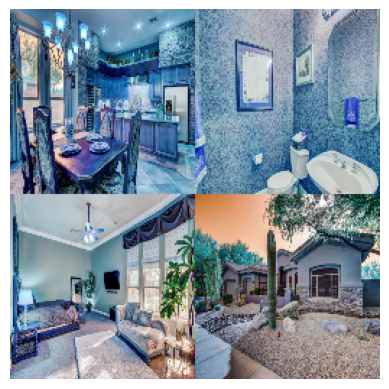

In [26]:
plt.imshow(train_data["multi_image"].iloc[0])
plt.axis("off")
plt.show()

In [5]:
x_train, y_train = get_model_data(train_data)

In [7]:
x_train.keys()

dict_keys(['bedroom_image_input', 'bathroom_image_input', 'kitchen_image_input', 'frontal_image_input', 'textual_data'])

In [10]:
x_train["bedroom_image_input"].shape
x_train["bedroom_image_input"].dtype

dtype('float32')

In [ ]:
print(data.shape)
print(data.dtype)
data_ = np.resize(data, (len(data), 128, 128, 3))
print(data_.shape)
print(data_.dtype)
for image in data:
    print("\n")
    print(image.shape)
    print(image.dtype)
    for channel in range(3):
        print(image[:, :, channel].dtype)
        print(image[:, :, channel].shape)
        print("-------------------")

In [ ]:
data2 = np.array([image for image in data])
print(data2.shape)
print(data2.dtype)

In [ ]:
data_